In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')
from model import FinData
from model import train_valid_split
from model import CatboostFinModel

c:\Users\burko\OneDrive\Documents\GitHub\prices-predictions\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

# from model.data import FinData
# from model.preprocessing import train_valid_split
# from ..model.model import CatboostFinModel

In [4]:
data = FinData("../../datasets/T_yandex_10min.csv")

data.insert_all()
# data.make_binary_class_target()

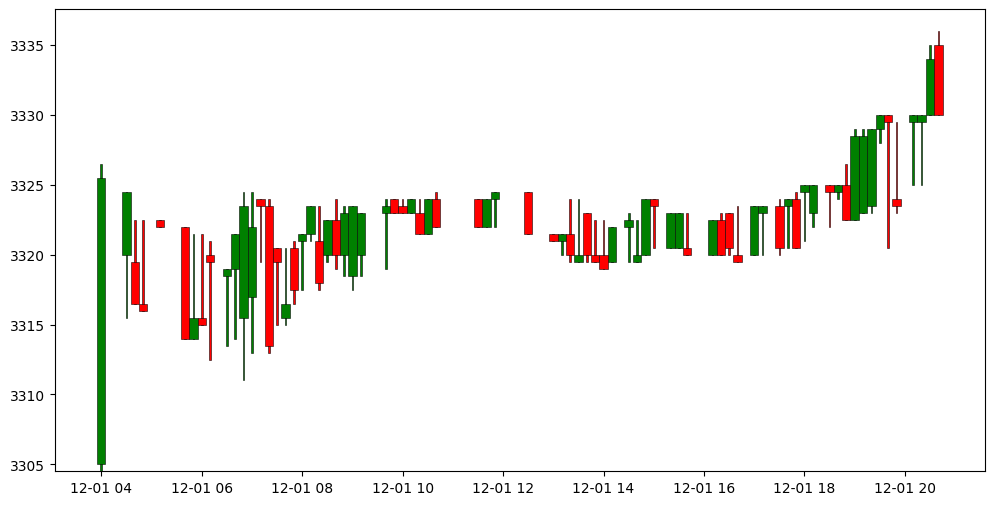

In [10]:
data.visualize_time_frame(dt.datetime(2024, 12, 1), dt.datetime(2024, 12, 2))

In [5]:
data.cat_features

['hours',
 'day',
 'minute',
 'is_holiday',
 'pred_holiday',
 'week_pred_holiday',
 'day_time',
 'season']

In [6]:
numeric = data.numeric_features[::5] + data.numeric_features[1::5]

cat = data.cat_features

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "reg_alpha" : 0.1, # L1
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

# data.restrict_time_down(2024, 11, 1)

In [7]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [13]:
y_train.shape

(134251,)

In [8]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

TypeError: CatBoostClassifier.__init__() got an unexpected keyword argument 'reg_alpha'

Посмотрим на фильтр Баттерворта

In [10]:
data2 = FinData("../../datasets/T_yandex_10min.csv")

data2.insert_shifts_norms([3, 6, 18])
data2.insert_rolling_means()
data2.insert_exp_rolling_means()
data2.insert_stochastic_oscillator()
data2.insert_high_low_diff()
data2.insert_butter_filter()
data2.insert_trend_rsi()
data2.insert_trend_rolling_means()
data2.insert_trend_deviation()



TypeError: FinData.make_binary_class_target() missing 1 required positional argument: 'target_name'

In [8]:
numeric = data2.numeric_features

cat = data2.cat_features

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

X_train, X_val, y_train, y_val = train_valid_split(data=data2.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()


0:	learn: 0.6563452	test: 0.6262626	best: 0.6262626 (0)	total: 178ms	remaining: 29m 36s
100:	learn: 0.6615891	test: 0.6363636	best: 0.6464646 (7)	total: 3.59s	remaining: 5m 52s
200:	learn: 0.6668926	test: 0.6363636	best: 0.6464646 (7)	total: 7.35s	remaining: 5m 58s
300:	learn: 0.6711160	test: 0.6464646	best: 0.6464646 (7)	total: 11s	remaining: 5m 55s
400:	learn: 0.6740434	test: 0.6414141	best: 0.6464646 (7)	total: 14.6s	remaining: 5m 49s
500:	learn: 0.6759354	test: 0.6565657	best: 0.6565657 (480)	total: 17.9s	remaining: 5m 38s
600:	learn: 0.6774624	test: 0.6666667	best: 0.6666667 (595)	total: 21.5s	remaining: 5m 35s
700:	learn: 0.6785499	test: 0.6717172	best: 0.6717172 (649)	total: 25.1s	remaining: 5m 32s
800:	learn: 0.6795331	test: 0.6717172	best: 0.6717172 (649)	total: 28.4s	remaining: 5m 25s
900:	learn: 0.6801514	test: 0.6717172	best: 0.6717172 (649)	total: 31.9s	remaining: 5m 21s
1000:	learn: 0.6805983	test: 0.6666667	best: 0.6717172 (649)	total: 35.3s	remaining: 5m 17s
1100:	learn

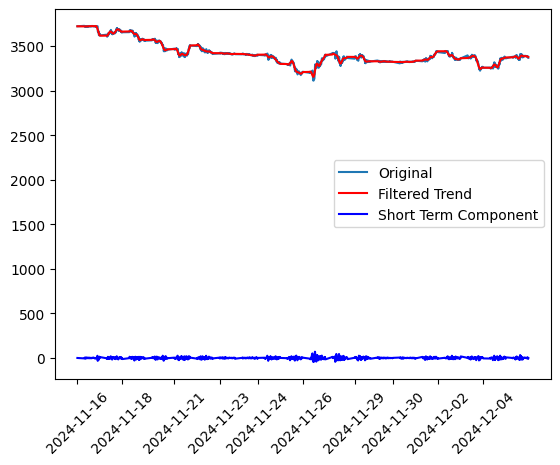

In [25]:
data2.restrict_time_down_stupidly(months=0, days=20)
data2.insert_butter_filter(visualise=True)

<Axes: xlabel='is_holiday', ylabel='Count'>

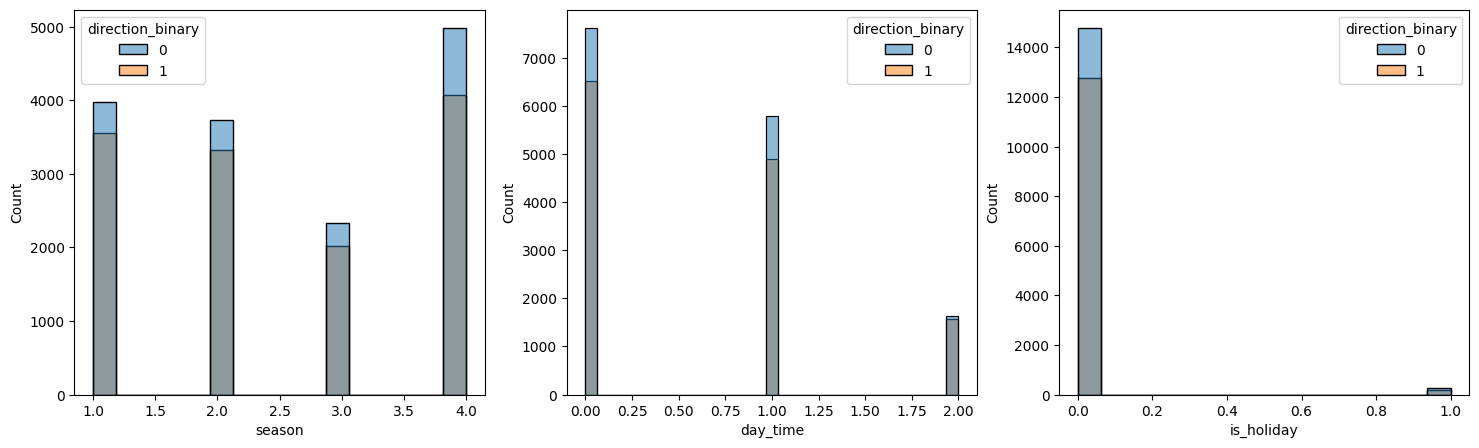

In [ ]:
data = FinData("../../datasets/T_yandex_10min.csv")
data.insert_seasons()
data.insert_holidays()
data.insert_time_features()

data.restrict_time_down(months=12)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(ax = axes[0], x=data.df['season'], hue=data.df['direction_binary'])
sns.histplot(ax = axes[1], x=data.df['day_time'], hue=data.df['direction_binary'])
sns.histplot(ax = axes[2], x=data.df['is_holiday'], hue=data.df['direction_binary'])

2.385930078540938e-08 2.0052612256191007e-08


<Axes: xlabel='utc', ylabel='close'>

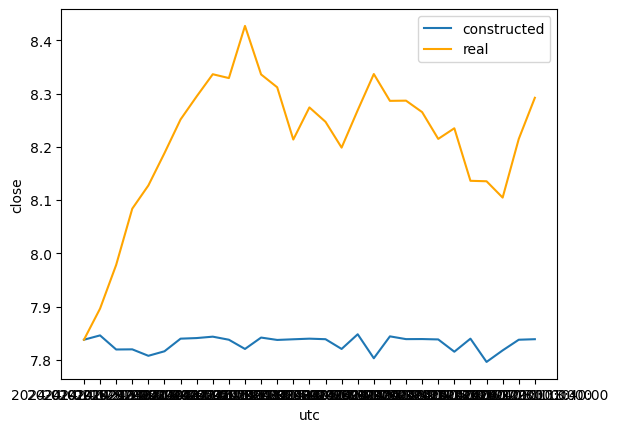

In [14]:
n = data.df.shape[0]

sum_s, sum_t = np.log1p(data.df['close'][0]), data.df['volume'][0]
for i in range(n - 1):
    sum_s += np.log1p(data.df['close'][i + 1]) - np.log1p(data.df['close'][i])
    sum_t += data.df['volume'][i + 1]

sum_s, sum_t = sum_s / n, sum_t / n
a = sum_s / sum_t

su = (np.log1p(data.df['close'][0]) - a * data.df['volume'][0]) / np.sqrt(data.df['volume'][0])
for i in range(n - 1):
    diff_t = data.df['volume'][i + 1]
    su += (np.log1p(data.df['close'][i + 1]) - np.log1p(data.df['close'][i]) - a * diff_t) / np.sqrt(diff_t)
su /= n

sigma2 = 0

for i in range(n - 1):
    diff_t = data.df['volume'][i + 1]
    sigma2 += ((np.log1p(data.df['close'][i + 1]) - np.log1p(data.df['close'][i]) - a * diff_t) / np.sqrt(diff_t) - su) ** 2

sigma2 /= n
print(a, sigma2)

m = 20000000
s = [0] * (m + 1)
x_t = [0] * (m + 1)
eps = np.random.choice([-1, 1], m)
for i in range(1, m + 1):
    s[i] = s[i - 1] + eps[i - 1]
    # x_t[i] = (s[i] / np.sqrt(m)) * np.sqrt(sigma2) + a * df['Trade_Count_csco'][i - 1]

def f(t):
    k = t * m
    if abs(k - int(k)) < 1e-6:
        return np.sqrt(m) * (s[int(k)] / np.sqrt(m))
    else:
        return  np.sqrt(m) * (s[int(k)] / np.sqrt(m) + (k - int(k)) * eps[int(k) + 1] / np.sqrt(m))

log_s0 = np.log1p(data.df['close'][0])
s_n = [log_s0] * n
for i in range(1, n):
    # print(a * df['T_n'][i], "-", f(df['T_n'][i] / m) * np.sqrt(sigma2))
    s_n[i] = log_s0 + a * data.df['volume'][i] + f(data.df['volume'][i] / m) * np.sqrt(sigma2)
    # s_n[i] = f(df['Trade_Count_csco'][i])
data2 = data.df[::1000]
sns.lineplot(x=data2['utc'].astype('str'), y=s_n[::1000], label='constructed')
sns.lineplot(x=data2['utc'].astype('str'), y=np.log1p(data2['close']), color='orange', label='real')

In [28]:
from catboost import CatBoostClassifier, Pool

data = FinData("../../datasets/Yandex_1_min.csv")
data.insert_all()

numeric = data.numeric_features
cat = data.cat_features
args = {"iterations" : 1000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Logloss', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}
data.restrict_time_down(dt.datetime(2024, 12, 25))

X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=29, 
                                                   numeric=numeric, cat=cat, target="direction_binary_0")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

sm = model.score(X_val, 1 - y_val, output_dict=True)

test_pool = Pool(X_val, label=y_val)

# # Train the model
# model.fit(train_pool)

# Evaluate the model using CatBoost metrics
metrics = model.model.eval_metrics(test_pool, 
                             metrics=['Logloss'])


c:\Users\burko\OneDrive\Documents\GitHub\prices-predictions\examples\my_bottle_2\../..\model\features\smoothing_features.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'ma_{i}'] = self.df['close'].rolling(window = i, closed="left").mean()
c:\Users\burko\OneDrive\Documents\GitHub\prices-predictions\examples\my_bottle_2\../..\model\features\smoothing_features.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'close_normed_ma_{i}'] = self.df['close']/self.df[f'ma_{i}']
c:\Users\burko\OneDrive\Documents\Gi

0:	learn: 0.6925247	test: 0.6921187	best: 0.6921187 (0)	total: 37.6ms	remaining: 37.6s
100:	learn: 0.6626030	test: 0.6333316	best: 0.6333316 (100)	total: 1.3s	remaining: 11.6s
200:	learn: 0.6507442	test: 0.6125133	best: 0.6125133 (200)	total: 2.7s	remaining: 10.8s
300:	learn: 0.6427656	test: 0.6041244	best: 0.6041244 (300)	total: 4.04s	remaining: 9.39s
400:	learn: 0.6367154	test: 0.5995409	best: 0.5995409 (400)	total: 5.45s	remaining: 8.15s
500:	learn: 0.6313644	test: 0.5961589	best: 0.5961589 (500)	total: 7.49s	remaining: 7.46s
600:	learn: 0.6264413	test: 0.5935561	best: 0.5935561 (599)	total: 9.41s	remaining: 6.25s
700:	learn: 0.6214386	test: 0.5916169	best: 0.5916169 (700)	total: 11.2s	remaining: 4.77s
800:	learn: 0.6167384	test: 0.5904662	best: 0.5904330 (798)	total: 13.1s	remaining: 3.27s
900:	learn: 0.6111962	test: 0.5889317	best: 0.5889317 (900)	total: 14.9s	remaining: 1.64s
999:	learn: 0.6053562	test: 0.5879460	best: 0.5879430 (996)	total: 16.6s	remaining: 0us

bestTest = 0.587

Cannot restore border parameter, falling to default border = 0.5


In [30]:
# metrics['Logloss'][-1]
sm

{'0': {'precision': 0.30266444629475436,
  'recall': 0.716256157635468,
  'f1-score': 0.42551946151594966,
  'support': 1015.0},
 '1': {'precision': 0.38064516129032255,
  'recall': 0.09557235421166306,
  'f1-score': 0.15278377211911956,
  'support': 1852.0},
 'accuracy': 0.3153121730031392,
 'macro avg': {'precision': 0.34165480379253843,
  'recall': 0.40591425592356556,
  'f1-score': 0.2891516168175346,
  'support': 2867.0},
 'weighted avg': {'precision': 0.3530377578300848,
  'recall': 0.3153121730031392,
  'f1-score': 0.24934000676780546,
  'support': 2867.0}}

In [30]:
data.df['random_prediction'] = np.exp(s_n)

numeric = data.numeric_features + ['random_prediction']
cat = data.cat_features
args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=8, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

model.score(X_val, y_val, output_dict=True)


0:	learn: 0.5736866	test: 0.5924784	best: 0.5924784 (0)	total: 7.2ms	remaining: 1m 12s
100:	learn: 0.5821625	test: 0.5979084	best: 0.5986458 (85)	total: 900ms	remaining: 1m 28s
200:	learn: 0.5862095	test: 0.5995173	best: 0.5997184 (194)	total: 1.83s	remaining: 1m 29s
300:	learn: 0.5897984	test: 0.6013273	best: 0.6016625 (273)	total: 2.61s	remaining: 1m 24s
400:	learn: 0.5943036	test: 0.6020648	best: 0.6026681 (381)	total: 3.39s	remaining: 1m 21s
500:	learn: 0.5986561	test: 0.6017966	best: 0.6026681 (381)	total: 4.12s	remaining: 1m 18s
600:	learn: 0.6034667	test: 0.6028022	best: 0.6036737 (598)	total: 4.93s	remaining: 1m 17s
700:	learn: 0.6095754	test: 0.6021988	best: 0.6036737 (598)	total: 5.7s	remaining: 1m 15s
800:	learn: 0.6145388	test: 0.6028022	best: 0.6036737 (598)	total: 6.55s	remaining: 1m 15s
900:	learn: 0.6190440	test: 0.6028022	best: 0.6036737 (598)	total: 7.36s	remaining: 1m 14s
1000:	learn: 0.6238546	test: 0.6033385	best: 0.6038077 (980)	total: 8.21s	remaining: 1m 13s
1100

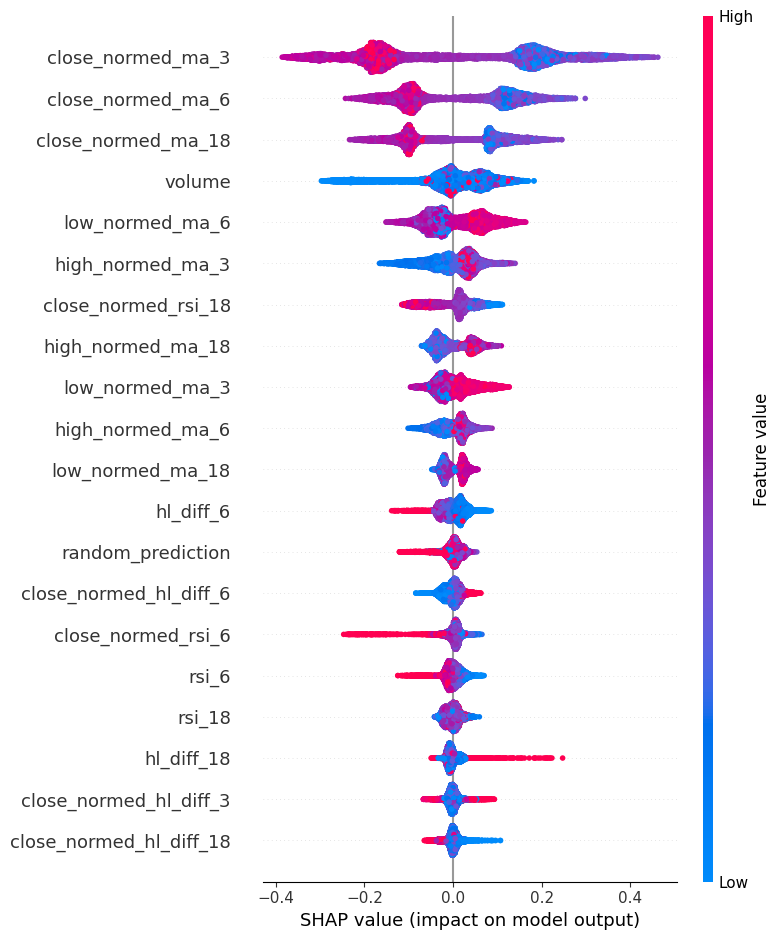

In [31]:
model.visualise_shap_values()

In [79]:
import pandas as pd

df = pd.read_csv('../../markettwits_with_hashtags.csv').dropna()
df

,ID,Text,Date,list_of_hashtags
0,315744,💥🇺🇸#INTC \nIntel назначил нового CEO,2025-03-12 20:30:54+00:00,['#INTC']
1,315743,✴️#крипто #наблюдение \nSantiment отмечает рез...,2025-03-12 20:26:21+00:00,"['#крипто', '#наблюдение']"
2,315742,💥🇺🇸#TSLA = +7% #NVDA = +6.5% на закрытии,2025-03-12 20:20:07+00:00,"['#TSLA', '#NVDA']"
3,315741,⚠️🇨🇦#дкп #канада #спикеры \nЦБ обсуждал паузу ...,2025-03-12 20:14:08+00:00,"['#дкп', '#канада', '#спикеры']"
4,315740,🛢🇺🇸#event #нефтегаз #сша \nРуководители нефтян...,2025-03-12 20:09:14+00:00,"['#event', '#нефтегаз', '#сша']"
...,...,...,...,...
43867,270925,🇺🇸#сша #отчетности\nкорпоративные отчетности С...,2024-01-01 15:34:44+00:00,"['#сша', '#отчетности']"
43868,270924,✴️#крипто #разблокировки #календарь \nCryptora...,2024-01-01 15:30:52+00:00,"['#крипто', '#разблокировки', '#календарь']"
43869,270923,✴️#крипто #разблокировки #календарь \nCryptora...,2024-01-01 15:29:45+00:00,"['#крипто', '#разблокировки', '#календарь']"
43870,270921,🗓#календарь\nКЛЮЧЕВЫЕ СОБЫТИЯ ЭТОЙ НЕДЕЛИ:\n\n...,2024-01-01 15:24:42+00:00,['#календарь']


In [80]:
def str_to_list(cell):
    cell = ''.join(c for c in cell if c not in "'[]")
    cell = cell.split(', ')
    return cell

df['list_of_hashtags'] = df['list_of_hashtags'].apply(lambda x: str_to_list(x))
df

,ID,Text,Date,list_of_hashtags
0,315744,💥🇺🇸#INTC \nIntel назначил нового CEO,2025-03-12 20:30:54+00:00,[#INTC]
1,315743,✴️#крипто #наблюдение \nSantiment отмечает рез...,2025-03-12 20:26:21+00:00,"[#крипто, #наблюдение]"
2,315742,💥🇺🇸#TSLA = +7% #NVDA = +6.5% на закрытии,2025-03-12 20:20:07+00:00,"[#TSLA, #NVDA]"
3,315741,⚠️🇨🇦#дкп #канада #спикеры \nЦБ обсуждал паузу ...,2025-03-12 20:14:08+00:00,"[#дкп, #канада, #спикеры]"
4,315740,🛢🇺🇸#event #нефтегаз #сша \nРуководители нефтян...,2025-03-12 20:09:14+00:00,"[#event, #нефтегаз, #сша]"
...,...,...,...,...
43867,270925,🇺🇸#сша #отчетности\nкорпоративные отчетности С...,2024-01-01 15:34:44+00:00,"[#сша, #отчетности]"
43868,270924,✴️#крипто #разблокировки #календарь \nCryptora...,2024-01-01 15:30:52+00:00,"[#крипто, #разблокировки, #календарь]"
43869,270923,✴️#крипто #разблокировки #календарь \nCryptora...,2024-01-01 15:29:45+00:00,"[#крипто, #разблокировки, #календарь]"
43870,270921,🗓#календарь\nКЛЮЧЕВЫЕ СОБЫТИЯ ЭТОЙ НЕДЕЛИ:\n\n...,2024-01-01 15:24:42+00:00,[#календарь]


In [82]:
set_of_red_flags = {'#INTC', '#крипто'}
mask = df['list_of_hashtags'].apply(lambda x: len(set_of_red_flags.intersection(set(x))) == 0)
df1 = df[mask]
df1

,ID,Text,Date,list_of_hashtags
2,315742,💥🇺🇸#TSLA = +7% #NVDA = +6.5% на закрытии,2025-03-12 20:20:07+00:00,"[#TSLA, #NVDA]"
3,315741,⚠️🇨🇦#дкп #канада #спикеры \nЦБ обсуждал паузу ...,2025-03-12 20:14:08+00:00,"[#дкп, #канада, #спикеры]"
4,315740,🛢🇺🇸#event #нефтегаз #сша \nРуководители нефтян...,2025-03-12 20:09:14+00:00,"[#event, #нефтегаз, #сша]"
5,315739,🇺🇸#экономика #сша #опрос \n41% американцев счи...,2025-03-12 19:40:49+00:00,"[#экономика, #сша, #опрос]"
6,315738,🌎#медь\nСША могут нарастить импорт меди на 50-...,2025-03-12 19:34:07+00:00,[#медь]
...,...,...,...,...
43865,270927,🛢🇧🇷#бразилия #опек #нефть \nБразилия с 1 январ...,2024-01-01 15:50:05+00:00,"[#бразилия, #опек, #нефть]"
43866,270926,🇨🇳#LI #XPEV #NIO #BYD #отчетность \nBYD - пост...,2024-01-01 15:45:05+00:00,"[#LI, #XPEV, #NIO, #BYD, #отчетность]"
43867,270925,🇺🇸#сша #отчетности\nкорпоративные отчетности С...,2024-01-01 15:34:44+00:00,"[#сша, #отчетности]"
43870,270921,🗓#календарь\nКЛЮЧЕВЫЕ СОБЫТИЯ ЭТОЙ НЕДЕЛИ:\n\n...,2024-01-01 15:24:42+00:00,[#календарь]


In [83]:
set_of_must = {'#экономика', '#сша'}
mask = df1['list_of_hashtags'].apply(lambda x: len(set_of_must.difference(set(x))) == 0)
df2 = df1[mask]
df2

,ID,Text,Date,list_of_hashtags
5,315739,🇺🇸#экономика #сша #опрос \n41% американцев счи...,2025-03-12 19:40:49+00:00,"[#экономика, #сша, #опрос]"
12,315732,❗️🇺🇸#сша #экономика #бюджет #отчетность \nФеде...,2025-03-12 18:01:33+00:00,"[#сша, #экономика, #бюджет, #отчетность]"
83,315661,🔥🇺🇸#инфляция #сша #отчетность #экономика \nСША...,2025-03-12 12:30:14+00:00,"[#инфляция, #сша, #отчетность, #экономика]"
130,315614,⚠️🇺🇸#рецессия #сша #экономика \nPimco повысили...,2025-03-12 06:53:36+00:00,"[#рецессия, #сша, #экономика]"
131,315613,⚠️🇺🇸#рецессия #торговыевойны #сша #экономика \...,2025-03-12 06:50:38+00:00,"[#рецессия, #торговыевойны, #сша, #экономика]"
...,...,...,...,...
43630,271165,🇺🇸#сша #экономика #отчетность \nСША -ADP Nonfa...,2024-01-04 13:15:04+00:00,"[#сша, #экономика, #отчетность]"
43699,271096,❗️🇺🇸#экономика #дкп #сша \nСамый большой риск ...,2024-01-04 05:14:53+00:00,"[#экономика, #дкп, #сша]"
43722,271072,🇺🇸#сша #экономика #отчетность \nСША -ISM Manuf...,2024-01-03 15:00:04+00:00,"[#сша, #экономика, #отчетность]"
43814,270979,🇺🇸#рецессия #сша #экономика \nу ФРС определенн...,2024-01-02 19:57:24+00:00,"[#рецессия, #сша, #экономика]"
